In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

import pyrtools as pt
from plenoptic.tools.signal import rcosFn, pointOp
%matplotlib inline

from plenoptic.simulate import Steerable_Pyramid_Freq
from plenoptic.tools.display import convert_pyrshow
from plenoptic.tools.data import torch_complex_to_numpy, to_numpy
dtype = torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%load_ext autoreload

%autoreload 2


This tutorial walks through the basic features of the torch implementation of the Steerable Pyramid. We use the steerable pyramid construction in the frequency domain (such that it provides perfect reconstruction and any number of orientation bands). For more details on steerable pyramids and how they are built, see the pyrtools tutorial at: https://pyrtools.readthedocs.io/en/latest/. 
Here we will specifically focus on the specifics of the torch version and how it may be used in concert with other differentiable torch models. 
First, let's instantiate a pyramid and visualize the impulse response. This is done by creating an impulse in each band of the pyramid and then using the recon_pyr function to reconstruct the image based on each band separately. 

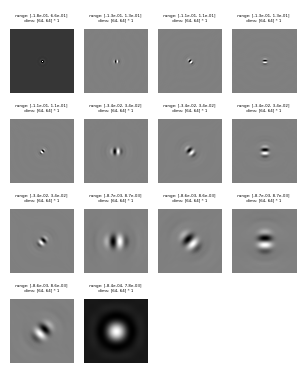

In [2]:
order = 3
imsize = 64
pyr = Steerable_Pyramid_Freq(height=3,image_shape=[imsize,imsize],order=order,is_complex = False,twidth=1, downsample=True)
pyr.to(device)
empty_image = torch.zeros((1,1,imsize,imsize),dtype=dtype).to(device)
pyr_coeffs = pyr.forward(empty_image)

for k,v in pyr.pyr_size.items():
    mid = (v[0]//2, v[1]//2)
    pyr_coeffs[k][0,0,mid[0],mid[1]]=1

reconList = []
for k in pyr_coeffs.keys():
    if isinstance(k, tuple):
        reconList.append(to_numpy(pyr.recon_pyr(k[0], k[1]).squeeze()))
    else:
        reconList.append(to_numpy(pyr.recon_pyr(k)).squeeze())
        
pt.imshow(reconList, col_wrap=order+1, vrange='indep1', zoom=1);

We can see that this pyramid is representing a 4 scale 4 orientation decomposition. Now let's see what the steerable pyramid representation for images look like. <br>  
Unlike the pyrtools version, because we are using torch we can perform batch computations with the steerable pyramid implementation. Therefore, the input can be a tensor of size (B x C x H x W). In general C = 1, because the pyramid is meant to operate on gray-scale images, but in the current implementation C > 1 will cause the pyramid to run independently on each channel. The output of the real pyramid will be (B x C x H x W): 

torch.Size([2, 1, 256, 256])


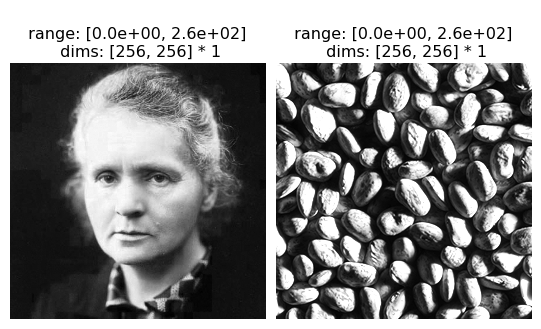

In [3]:
im1 = torch.tensor(plt.imread('../data/curie.pgm').astype(float), dtype=dtype).to(device)
im2 = torch.tensor(plt.imread('../data/nuts.pgm').astype(float), dtype=dtype).to(device)
im_batch = torch.stack((im1, im2),0).unsqueeze(1)
print(im_batch.shape)
pt.imshow(im_batch.squeeze().data.cpu().numpy())
order = 3
pyr = Steerable_Pyramid_Freq(height=4,image_shape=[256,256],order=order,is_complex = False,twidth=1, downsample=True)
pyr.to(device)
pyr_coeffs = pyr(im_batch)

In the default, the output of the pyramid is stored as a dictionary whose keys are either a string for the 'residual_lowpass' and 'residual_highpass' bands or a tuple of (scale_index, orientation_index). In order to visualize, the pyr_coeffs for each image and channel, in the batch, we can use the following:

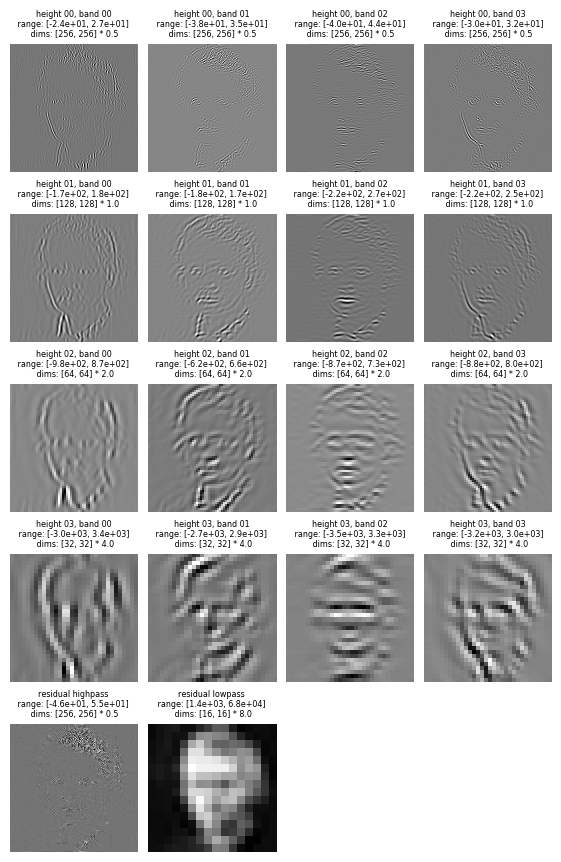

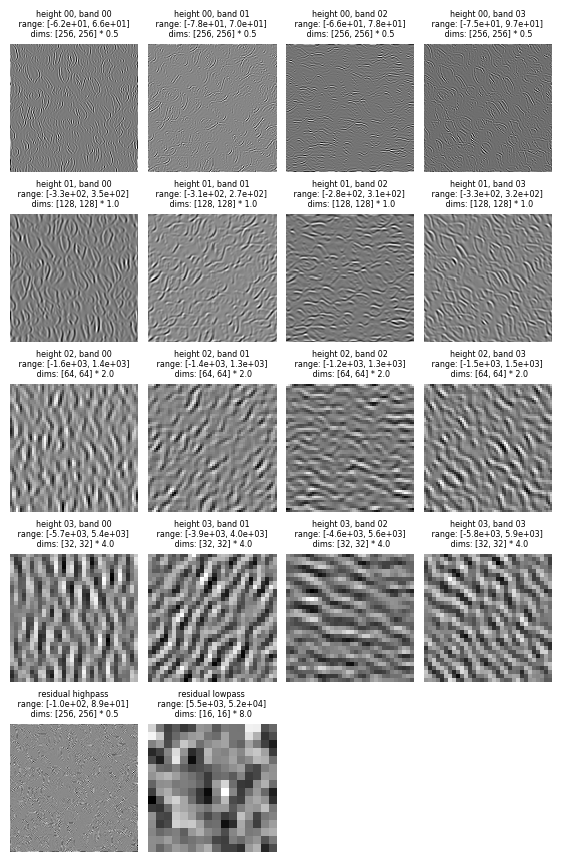

In [4]:
display_coeffs1 = convert_pyrshow(channel=0, image_index=0, pyr_coeffs=pyr_coeffs)
display_coeffs2 = convert_pyrshow(channel=0, image_index = 1, pyr_coeffs = pyr_coeffs)
pt.pyrshow(display_coeffs1,zoom=0.5,is_complex = False,vrange='indep');
pt.pyrshow(display_coeffs2,zoom=0.5,is_complex = False,vrange='indep');

A feature of the pyramid implementation is however, we don't need to output all scales of the pyramid during the forward if they are not necessary. This functionality is especially useful for coarse-to-fine optimization procedures. We can easily change the output of pyramid by passing a `scales` argument to the forward pass as follows:

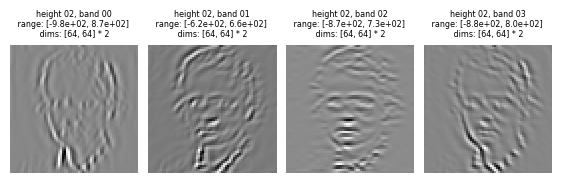

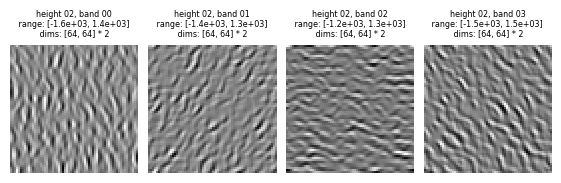

In [5]:
#get the 3rd scale
pyr_coeffs_scale0 = pyr(im_batch, scales=[2])
display_coeffs1 = convert_pyrshow(channel=0, image_index=0, pyr_coeffs=pyr_coeffs_scale0)
display_coeffs2 = convert_pyrshow(channel=0, image_index = 1, pyr_coeffs = pyr_coeffs_scale0)
pt.pyrshow(display_coeffs1,zoom=2,is_complex = False,vrange='indep');
pt.pyrshow(display_coeffs2,zoom=2,is_complex = False,vrange='indep');

The above pyramid was the real pyramid but in many applications we might want the full complex pyramid output. This can be set using the 'is_complex' argument. When this is true, the output of the pyramid will be of shape (BxCxHxWx2) where the last dimension holds the real (index 0) and imaginary (index 1) components:

In [6]:
order = 3
height = 3
pyr_complex = Steerable_Pyramid_Freq(height=height,image_shape=[256,256],order=order,is_complex = True,twidth=1, downsample=True)
pyr_complex.to(device)
pyr_coeffs_complex = pyr_complex(im_batch)

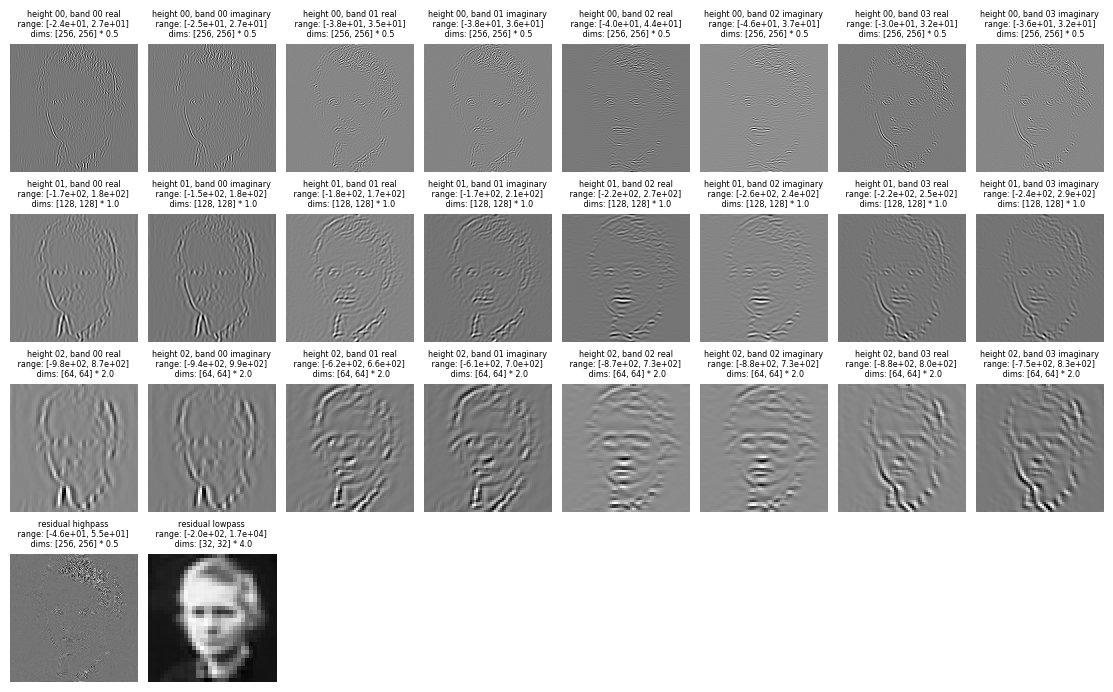

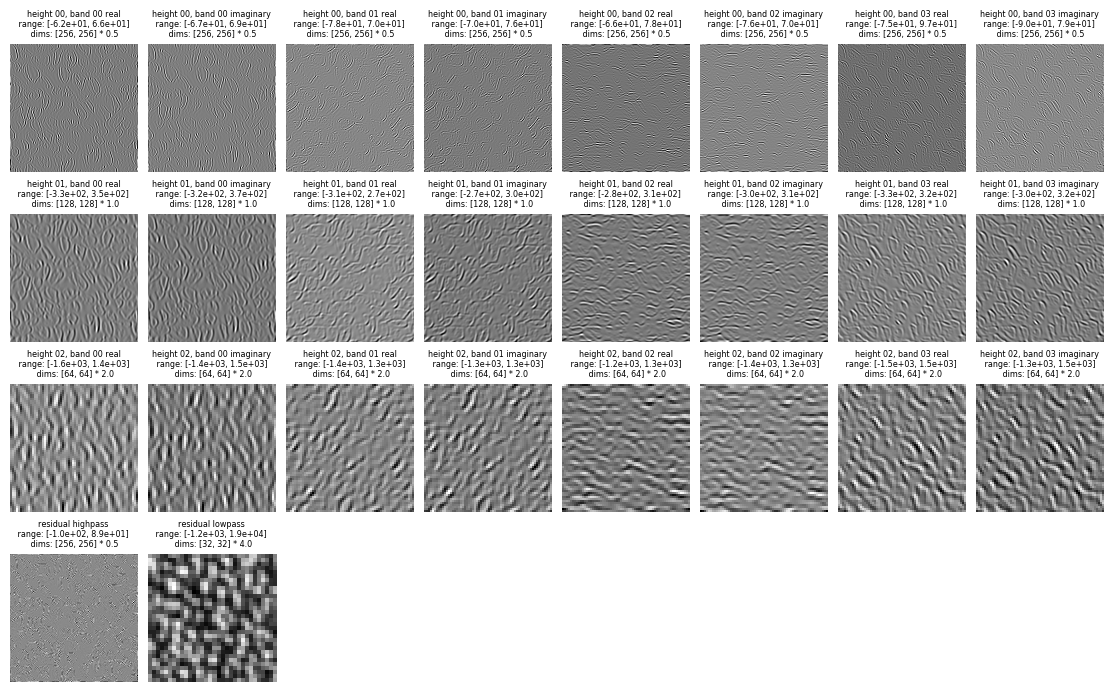

In [7]:
display_coeffs1 = convert_pyrshow(channel=0, image_index=0, pyr_coeffs=pyr_coeffs_complex)
display_coeffs2 = convert_pyrshow(channel=0, image_index = 1, pyr_coeffs = pyr_coeffs_complex)
pt.pyrshow(display_coeffs1,zoom=0.5,is_complex = True,vrange='indep');
pt.pyrshow(display_coeffs2,zoom=0.5,is_complex = True,vrange='indep');

What if we wanted to use the steerable pyramid as a front-end for a deep CNN or other model? Most standard model architectures only accept channels with fixed shape, but each scale of the pyramid coefficients has a different shape (because each scale is downsampled by a factor of 2). In order to obtain an output amenable to downstream processing by standard torch nn modules, we have created an argument to the pyramid that does not downsample the frequency masks at each scale and thus maintains output feature maps that all have a fixed size. Let's try this and look at the first image both in the downsampled and not downsampled versions:

In [8]:
pyr_fixed  = Steerable_Pyramid_Freq(height=height,image_shape=[256,256],order=order,is_complex = True,twidth=1, downsample=False)
pyr_fixed.to(device)
pyr_coeffs_fixed = pyr_fixed(im_batch)

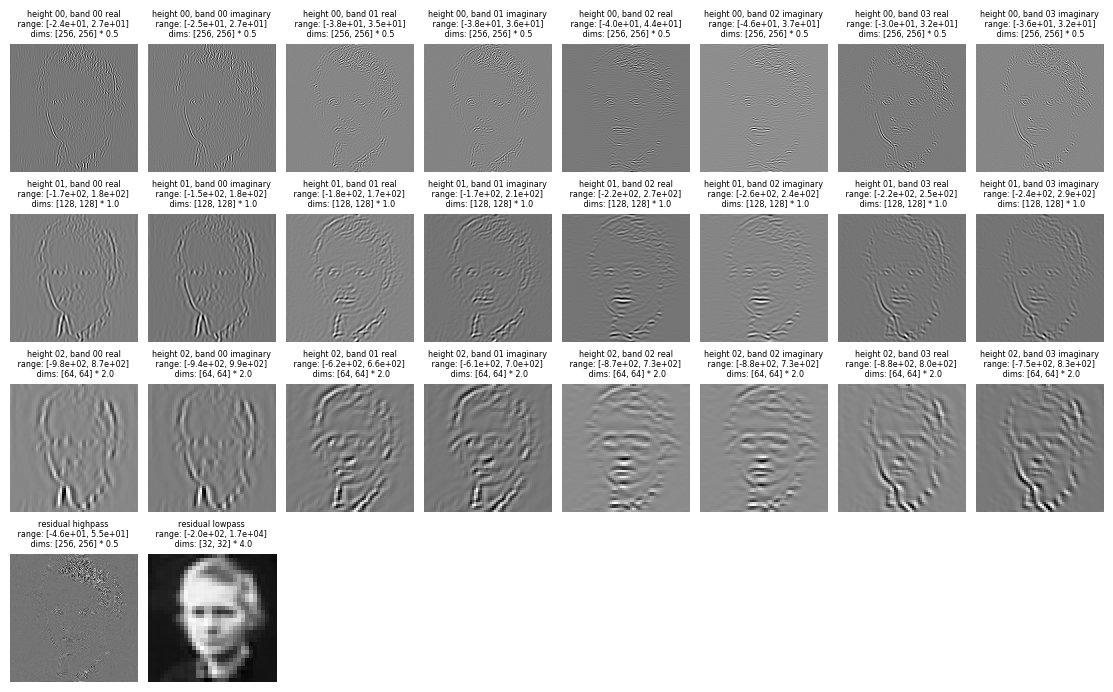

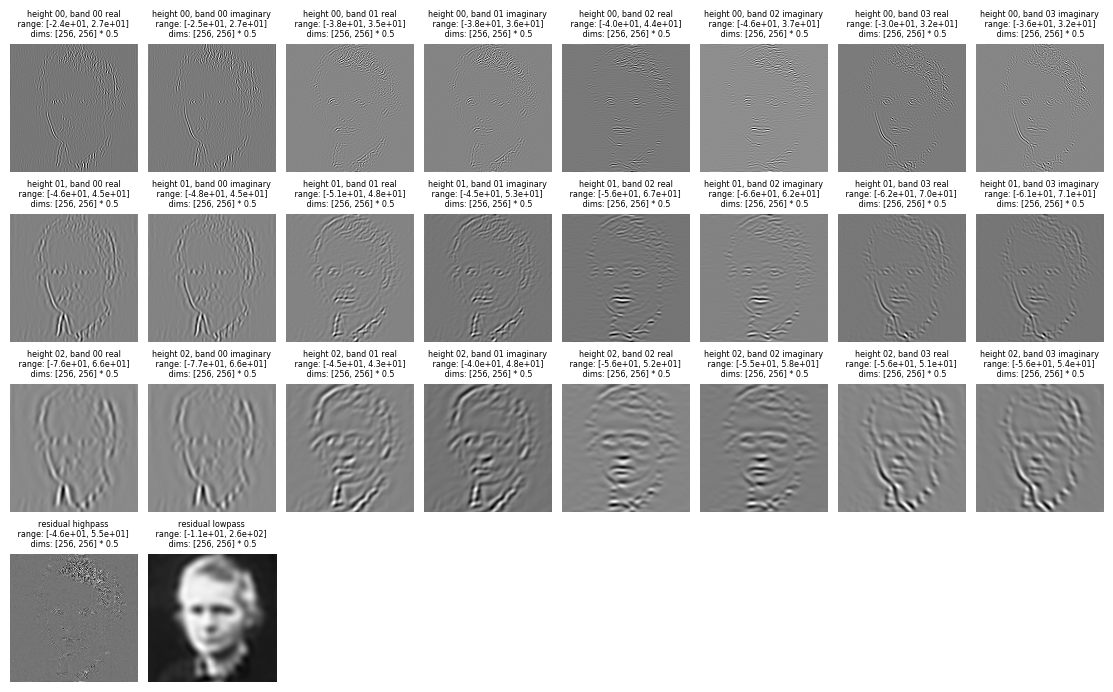

In [9]:
display_coeffs1 = convert_pyrshow(channel=0, image_index=0, pyr_coeffs=pyr_coeffs_complex)
display_coeffs2 = convert_pyrshow(channel=0, image_index = 0, pyr_coeffs = pyr_coeffs_fixed)
pt.pyrshow(display_coeffs1,zoom=0.5,is_complex = True,vrange='indep');
pt.pyrshow(display_coeffs2,zoom=0.5,is_complex = True,vrange='indep');

We can see that the not downsampled version maintains the same features as the original pyramid, but with fixed feature maps that have spatial dimensions equal to the original image (256x256). However, the pixel magnitudes in the bands are different due to the fact that we are not downsampling in the frequency domain anymore. This can equivalently be thought of as the inverse operation of blurring and downsampling. Therefore the upsampled versions of each scale are not simply zero interpolated versions of the downsampled versions and thus the pixel values are non-trivially changed.
2)The fft is not normalized whereas the ifft is normalized by 1/N. Because the size of the bands is fixed to 256x256 this will change this normalization factor in comparison with the downsampled version. This changes the relative energy between bands in each scale. However, if we use the normalized ffts, then the energy in each band should be equal between the downsampled and not downsampled pyramids (even though the pixel values are changed). We can check this by computing the energy in each band for the two pyramids, with the argument `fft_normalize = True`

In [10]:
pyr_fixed  = Steerable_Pyramid_Freq(height=height,image_shape=[256,256],order=order,is_complex = True,twidth=1, downsample=False, fft_normalize=True)
pyr_downsample = Steerable_Pyramid_Freq(height=height, image_shape=[256,256], order=order, is_complex = True, twidth = 1, fft_normalize=True)
pyr_coeffs_fixed = pyr_fixed(im_batch)
pyr_coeffs_downsample = pyr_downsample(im_batch)


for k, v in pyr_coeffs_fixed.items():
    v1 = pyr_coeffs_fixed[k].squeeze()
    v2 = pyr_coeffs_downsample[k].squeeze()
    if v1.shape[-1]==2:
        v1 = torch_complex_to_numpy(v1)
        v2 = torch_complex_to_numpy(v2)
    else:
        v1 = to_numpy(v1)
        v2 = to_numpy(v2)
    #check if energies match in each band between downsampled and fixed size pyramid responses
    print(np.allclose(np.sum(np.abs(v1)**2), np.sum(np.abs(v2)**2), rtol=1e-5, atol=1e-5))

    

True
True
True
True
True
True
True
True
True
True
True
True
True
True


Now, to use this steerable pyramid output with a downstream nn module, the output dictionary format is a bit hard to deal with. As a result, we now show how to create a tensor output for the pyramid in the form BxCxHxW. To do this, we can write a function `convert_to_tensor` that takes in a dictionary of coefficients and converts to a pytorch tensor a set of the channels from the pyr_coeffs dictionary:

In [11]:
pyr_fixed = Steerable_Pyramid_Freq(height=height,image_shape=[256,256],order=order,is_complex = True,twidth=1, downsample=False)
pyr_fixed.to(device)
pyr_coeffs_fixed = pyr_fixed(im_batch)

#Let's see what the shapes of the bands in the pyramid are:
for k,v in pyr_coeffs_fixed.items():
    print('Band ' + str(k) + ' size:' + str(v.shape))
    
#Let's create a function to convert the dictionary to a tensor. If the pyramid is real, all bands just become channels.
#If the pyramid is complex the bands and real/imaginary components all become channels.
#Note this function is implemented in plenoptic.tools.data

def convert_pyr_to_tensor(pyr_coeffs, exclude = [], is_complex = True):
    '''
    Function that takes a torch pyramid and converts the output into a single tensor
    of BxCxHxW for use in an nn module downstream. 
    
    Parameters
    ----------
    pyr_coeffs: `OrderedDict`
        the pyramid coefficients
    exclude: `list`
        list of bands to include, can include 'residual_lowpass', 'residual_highpass' or tuple (ind, ind)
    is_complex: `bool`
        boolean indicating whether complex pyramid is used or not
        
    '''
    coeff_list = []
    coeff_list_resid = []
    for k in pyr_coeffs.keys():
        if k not in exclude:
            if 'residual' in k:
                coeff_list_resid.append(pyr_coeffs[k])
            else:
                coeff_list.append(pyr_coeffs[k])
    
    coeff_bands = torch.cat(coeff_list, dim=1)
    batch_size = coeff_bands.shape[0]
    imshape = [coeff_bands.shape[2], coeff_bands.shape[3]]
    if is_complex:
        coeff_bands = coeff_bands.permute(0,1,4,2,3).contiguous().view(batch_size,-1,imshape[0],imshape[1])
    if len(coeff_list_resid) > 0:
        coeff_resid = torch.cat(coeff_list_resid, dim=1)
        coeff_out = torch.cat([coeff_bands, coeff_resid], dim=1)
    else:
        coeff_out = coeff_bands
    
    return coeff_out


pyr_coeff_tensor = convert_pyr_to_tensor(pyr_coeffs_fixed, exclude = ['residual_lowpass', 'residual_highpass'], is_complex = True)

#Now we have the 16 bands (8 real and then 8 imaginary as channels)
print(pyr_coeff_tensor.shape)


Band residual_highpass size:torch.Size([2, 1, 256, 256])
Band (0, 0) size:torch.Size([2, 1, 256, 256, 2])
Band (0, 1) size:torch.Size([2, 1, 256, 256, 2])
Band (0, 2) size:torch.Size([2, 1, 256, 256, 2])
Band (0, 3) size:torch.Size([2, 1, 256, 256, 2])
Band (1, 0) size:torch.Size([2, 1, 256, 256, 2])
Band (1, 1) size:torch.Size([2, 1, 256, 256, 2])
Band (1, 2) size:torch.Size([2, 1, 256, 256, 2])
Band (1, 3) size:torch.Size([2, 1, 256, 256, 2])
Band (2, 0) size:torch.Size([2, 1, 256, 256, 2])
Band (2, 1) size:torch.Size([2, 1, 256, 256, 2])
Band (2, 2) size:torch.Size([2, 1, 256, 256, 2])
Band (2, 3) size:torch.Size([2, 1, 256, 256, 2])
Band residual_lowpass size:torch.Size([2, 1, 256, 256])
torch.Size([2, 24, 256, 256])


Now let's create a simple model that takes the output of the pyramid, rectifies the coefficients and passes it through a convolutional layer model. 

In [15]:
class PyrConv(nn.Module):
    def __init__(self, imshape, order, scales, kernel_size, exclude = [], output_dim = 10, is_complex = True):
        super(PyrConv, self).__init__()
        
        self.imshape = imshape
        self.order = order
        self.scales = scales
        self.output_dim = output_dim
        self.kernel_size = kernel_size
        self.exclude = exclude
        self.is_complex = is_complex
        
        self.rect = nn.ReLU(inplace = True)
        self.pyr = Steerable_Pyramid_Freq(height=self.scales,image_shape=self.imshape,
                                          order=self.order,is_complex = self.is_complex,twidth=1, downsample=False)
        
        #channels number of scales * number of orientations * 2 (for the real/imag)
        self.pyr_channels = (self.order+1)*self.scales*2
        self.conv = nn.Conv2d(in_channels = self.pyr_channels,kernel_size = self.kernel_size, 
                              out_channels= self.output_dim, stride = 2)
        
    def forward(self, x):
        out = self.pyr(x)
        out = convert_pyr_to_tensor(out, exclude = self.exclude, is_complex = self.is_complex)
        out = self.rect(out)
        out = self.conv(out)

        return out

In [16]:
pyr_conv_model = PyrConv([256,256], 3, 2,5, exclude = ['residual_lowpass', 'residual_highpass'], output_dim = 20)

In [17]:
pyr_conv_resp = pyr_conv_model(im_batch)
print(pyr_conv_resp.shape)

torch.Size([2, 20, 126, 126])


Now to make sure we can use the full functionalities of torch, we can compute a loss and take a gradient step and see that gradients for the conv layer are computed for this model. 

In [18]:
loss = torch.norm(pyr_conv_resp, p=2)

In [19]:
loss.backward()

In [20]:
print(pyr_conv_model.conv.weight.grad)

tensor([[[[ 3.0938e+01,  1.4820e+01,  3.0715e+01,  5.4284e+01,  6.2173e+01],
          [ 3.4481e+01, -1.5039e+00,  2.7944e+01,  6.5242e+01,  6.6988e+01],
          [ 3.4696e+01, -5.4204e+00,  3.2892e+01,  7.0491e+01,  6.0393e+01],
          [ 2.9171e+01,  3.2183e+00,  4.2446e+01,  6.5876e+01,  4.9706e+01],
          [ 2.1695e+01,  1.5400e+01,  4.4059e+01,  5.9801e+01,  4.2055e+01]],

         [[ 4.9942e+01,  3.8985e+01,  1.2967e+01,  2.8583e+01,  5.2609e+01],
          [ 4.9336e+01,  4.4262e+01, -2.3120e+00,  1.9628e+01,  6.1928e+01],
          [ 4.4011e+01,  4.1563e+01, -5.4241e+00,  2.2978e+01,  6.8477e+01],
          [ 3.9645e+01,  3.2998e+01,  1.3496e+00,  3.4764e+01,  6.6549e+01],
          [ 3.8046e+01,  2.3212e+01,  1.2736e+01,  3.8693e+01,  6.0275e+01]],

         [[ 4.8712e+01,  3.5513e+01,  2.1019e+01,  3.6033e+01,  5.8612e+01],
          [ 3.9548e+01,  1.9183e+01,  2.4401e+01,  6.1618e+01,  7.4007e+01],
          [ 4.1941e+01,  2.7934e+01,  5.4559e+01,  8.5046e+01,  6.5706e+